In [13]:
import torch
import torchvision as t
import torchvision
import torchvision.transforms.functional as tvf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import os
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
import random
import sys
import timm
import torch
import torchvision
import skimage.transform as skTrans
import scipy.io
from airogs_dataset import Airogs

In [14]:
ckpt_path = '/home/wangqy/gardnet/Checkpoints/airogs_2.pt'
model = timm.create_model('efficientnet_b0',num_classes=2)
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
else:
    device = torch.device("cpu")
    model = model.to(device)
model = model.cuda()
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [15]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256,256))
])
dataset = Airogs(split='test',path='/home/wangqy/gardnet',
                 images_dir_name='dataset',apply_clahe=True,transforms=transforms)

test size: 10000


GT: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Pred: 0


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

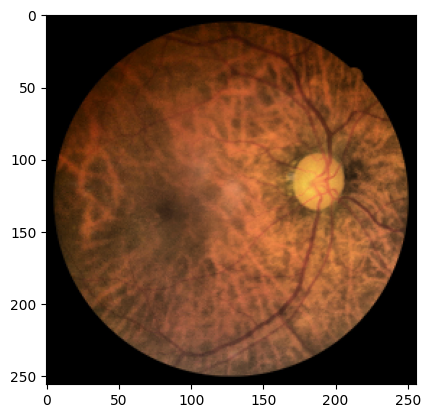

In [22]:
INDEX = 12 
image = dataset[INDEX][0]
plt.imshow(image.moveaxis(0,-1))
model.eval()
with torch.no_grad():
    x = image.unsqueeze(0).cuda()
    output = model(x)
    preds_prob = torch.nn.functional.softmax(output,dim=1)
    preds_label = torch.argmax(preds_prob,dim=1).item()
print(f"GT: {dataset[INDEX][0]}")
print(f"Pred: {preds_label}")


In [18]:

layer_gc = LayerGradCam(forward_func = model, layer = model.conv_head)

attribution = layer_gc.attribute(inputs = x,
                                 target = 1,
                                 attribute_to_layer_input=False,
                                 relu_attributions=True)
upsampled_attr = LayerAttribution.interpolate(attribution, (256,256),interpolate_mode='bilinear')


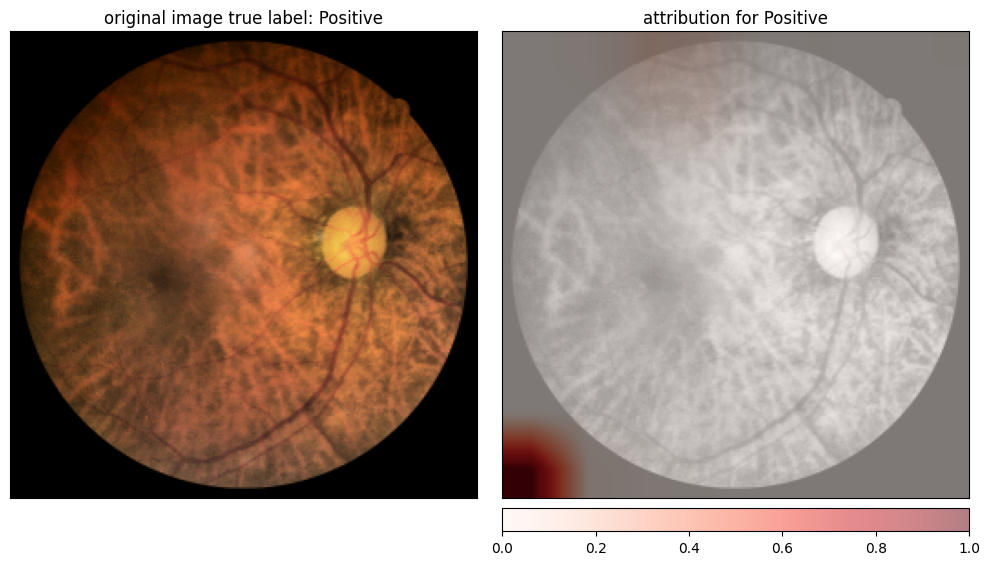

In [19]:
### class_names=['neg','pos']

fig,ax=viz.visualize_image_attr_multiple(
                                   attr            = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                   original_image  = np.transpose(x[0].cpu().detach().numpy(),(1,2,0)), # H,W,C
                                   methods         =  ["original_image", "blended_heat_map"],
                                   signs           =  ["all", "positive"],
                                   titles          = ['original image true label: Positive' , 
                                                        "attribution for Positive"
                                                     ],
                                   show_colorbar   = True,
                                   fig_size        = (10,10),
                                   cmap="Reds",
                                   use_pyplot = True
                                )
